# **Carlos Torre Rivas**

# Modelos de datos

**Notebook de seguimiento**

```
Ezequiel Cimadevilla Álvarez
ezequiel.cimadevilla@unican.es

Santander Meteorology Group
Instituto de Física de Cantabria
Edificio Juan Jordá, Avenida de los Castros, s/n, E-39005 Santander, Cantabria, Spain

http://www.meteo.unican.es

Máster Data Science/Ciencia de Datos - 2022/2023
```

## Contents

* [Intro](#intro)
* [h5py and random walker](#h5py-and-random-walker)
* [Chunking and filters](#chunking-and-filters)
* [netCDF](#netcdf)
* [Dimension scales](#dimension-scales)
* [Virtual dataset](#virtual-dataset)
* [Discrete Sampling Geometries](#dsg)
* [Zarr](#zarr)

# Intro <a class="anchor" id="intro"/>

In [1]:
import os

In [2]:
import h5py
import numpy as np

Follow the [tutorial](https://docs.h5py.org/en/stable/quick.html#appendix-creating-a-file) and answer the questions:

- Which modes are available in HDF5 when opening a File?

    * Modo Solo Lectura ('r'):

        Abre el archivo en modo solo lectura.
        Ejemplo: h5py.File('nombre_archivo.h5', 'r')

    * Modo Lectura-Escritura ('r+' o 'a'):

        Abre el archivo en modo lectura-escritura, permitiendo tanto la lectura como la escritura.
        Ejemplo: h5py.File('nombre_archivo.h5', 'r+') o h5py.File('nombre_archivo.h5', 'a')

    * Modo Solo Escritura ('w'):

        Crea un nuevo archivo o trunca un archivo existente a longitud cero para la escritura.
        Ejemplo: h5py.File('nombre_archivo.h5', 'w')

    * Modo Escritura-Solo ('w-'):

        Similar al modo solo escritura, pero genera un error si el archivo ya existe.
        Ejemplo: h5py.File('nombre_archivo.h5', 'w-')

- Which method/function can be used to recursively iter over an entire group?

    Podemos usar la función visit()

- Execute the following command in a terminal: `h5dump -A FILE`. What do you see?

    Realiza un volcado de toda la información que contenga un archivo perteneciente a hdf5




### Creating a file

In [10]:
# f = h5py.File("mytestfile.hdf5", "w")

In [11]:
f

<HDF5 file "mytestfile.hdf5" (mode r+)>

In [12]:
dset = f.create_dataset("mydataset", (100,), dtype='i')

manera alternativa de crear un dataset

In [41]:
# with h5py.File("mytestfile.hdf5", "w") as f:
#     dset = f.create_dataset("mydataset", (100,), dtype='i')

In [13]:
dset

<HDF5 dataset "mydataset": shape (100,), type "<i4">

### Conceptos básicos

In [14]:
f = h5py.File('mytestfile.hdf5', 'r') #abrimos el archivo para leerlo

<HDF5 file "mytestfile.hdf5" (mode r+)>

In [15]:
list(f.keys()) #h5py file funciona como un diccionario

['mydataset']

In [16]:
dset = f['mydataset']

In [19]:
print(dset.shape)
# Salida esperada: (100,)
print(dset.dtype)
# Salida esperada: dtype('int32')

(100,)
int32


In [20]:
import numpy as np
dset[...] = np.arange(100)
dset[0]
# Salida esperada: 0
dset[10]
# Salida esperada: 10
dset[0:100:10]
# Salida esperada: array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=int32)

### Grupos y organización jerarquica

In [38]:
dset.name # Cada objeto en un archivo HDF5 tiene un nombre

'/mydataset'

In [22]:
f.name # Las "carpetas" en este sistema se llaman grupos. El objeto File que creamos es en sí mismo un grupo, en este caso, el grupo raíz, llamado /

'/'

La creación de un subgrupo se logra a través del método create_group. Pero primero necesitamos abrir el archivo en modo "añadir" **a**

In [23]:
f = h5py.File('mydataset.hdf5', 'a')
grp = f.create_group("subgroup")

In [25]:
grp.name

'/subgroup'

Todos los objetos de tipo Group también tienen los métodos create_*

In [26]:
dset2 = grp.create_dataset("another_dataset", (50,), dtype='f')
dset2.name
# Salida esperada: '/subgroup/another_dataset'

'/subgroup/another_dataset'

In [27]:
dset3 = f.create_dataset('subgroup2/dataset_three', (10,), dtype='i') # no necesitas crear todos los grupos intermedios manualmente, se puede specificar una ruta completa
dset3.name
# Salida esperada: '/subgroup2/dataset_three'

'/subgroup2/dataset_three'

In [29]:
dataset_three = f['subgroup2/dataset_three']
dataset_three

<HDF5 dataset "dataset_three": shape (10,), type "<i4">

Iterar sobre un grupo proporciona los nombres de sus miembros

In [39]:
for name in f:
    print(name)
# Salida esperada:
# mydataset
# subgroup
# subgroup2

subgroup
subgroup2


In [33]:
"mydataset" in f
# Salida esperada: True

False

In [32]:
"somethingelse" in f
# Salida esperada: False

False

In [36]:
"subgroup/another_dataset" in f

True

In [37]:
def printname(name):
    print(name)
f.visit(printname)

subgroup
subgroup/another_dataset
subgroup2
subgroup2/dataset_three


### Atributos

In [43]:
dset.attrs['temperature'] = 99.5
print(dset.attrs['temperature'])

'temperature' in dset.attrs

99.5


True

## NumPy

This is just a small section to review Numpy. Execute the examples and solve the exercises.

In [44]:
import numpy as np

We can emulate multidimensional arrays using ragged arrays (arrays inside of arrays). Why is this a bad idea? Read [this](https://docs.python.org/3.7/faq/design.html#how-are-lists-implemented-in-cpython).

Los arrays desiguales pueden llevar a un uso ineficiente de la memoria. En un array multidimensional real, la memoria se asigna como un bloque contiguo, permitiendo un acceso y manipulación eficientes. En cambio, los arrays desiguales requieren asignaciones de memoria separadas para cada array interno, lo que puede resultar en un aumento de la sobrecarga de memoria.

In [45]:
l0 = [100, 200, 50, 400]
l1 = [50, 0, 0, 100]
l2 = [350, 100, 50, 200]
ls = [l0, l1, l2]
print(ls)

[[100, 200, 50, 400], [50, 0, 0, 100], [350, 100, 50, 200]]


Let's see how this performs compared to NumPy.

In [46]:
L = range(1000)
%timeit [i**2 for i in L]

240 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
a = np.arange(1000)
%timeit a**2

779 ns ± 9.21 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


La comprensión de lista en el rango (L) toma aproximadamente 240 microsegundos por bucle.
La operación de NumPy en el array (a) toma aproximadamente 779 nanosegundos por bucle.
Por lo tanto, la operación de NumPy es significativamente más eficiente en este caso particular. NumPy está optimizado para operaciones numéricas y aprovecha implementaciones eficientes en lenguajes de bajo nivel, como C, lo que permite un rendimiento mucho mejor en comparación con las operaciones similares en listas de Python estándar.

Let's see some NumPy properties.

In [56]:
a = np.array([[100, 200, 50, 400], [50, 0, 0, 100], [350, 100, 50, 200]])

print(a)

def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides) # strides are measured in bytes
    print('flags:')
    print(a.flags)
    
print_info(a)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]
number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



* Tipo de dato (data type): Muestra el tipo de dato de los elementos en el array. En tu caso, el tipo de dato es int64, lo que significa enteros de 64 bits.

* Desplazamientos (strides): Indica la cantidad de bytes que deben desplazarse para avanzar una posición en cada dimensión. En tu caso, los desplazamientos son (32, 8). Esto significa que para avanzar una posición en la primera dimensión, se deben saltar 32 bytes, y para avanzar una posición en la segunda dimensión, se deben saltar 8 bytes.

* Indicadores (flags):

    - C_CONTIGUOUS: Indica si el array es contiguo en memoria estilo C. En tu caso, es True.
    - F_CONTIGUOUS: Indica si el array es contiguo en memoria estilo Fortran. En tu caso, es False.
    - OWNDATA: Indica si el array es propietario de sus propios datos. En tu caso, es True.
    - WRITEABLE: Indica si los datos del array se pueden modificar. En tu caso, es True.
    - ALIGNED: Indica si los datos del array están alineados en memoria. En tu caso, es True.
    - WRITEBACKIFCOPY: Indica si se escribirán los datos de vuelta en la copia si se realiza una copia. En tu caso, es False.

Copies and views.

* astype se utiliza para realizar conversiones completas de tipo de datos y crea una nueva copia del array con el tipo de datos especificado y no almacena los datos en el mismo espacio de memoria que el array original. Al usar astype, se asigna un nuevo bloque de memoria para la copia con el tipo de datos deseado.

In [49]:
b = a.astype(np.uint8) # astype() always creates a copy of the data (pero con un tipo de dato diferente)
print_info(b)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: uint8
strides: (4, 1)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



* Cuando se utiliza view en NumPy, se está creando una nueva vista de los datos existentes en lugar de realizar una copia completa de los datos. Esto significa que la nueva vista comparte la memoria con el array original

In [57]:
abytes = a.ravel().view(dtype=np.uint8) # view() does not create a new copy of the data
print_info(abytes)

number of elements: 96
number of dimensions: 1
shape: (96,)
data type: uint8
strides: (1,)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [58]:
abytes

array([100,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,
         0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 144,   1,
         0,   0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,  94,
         1,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,
         0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,
         0,   0,   0,   0,   0], dtype=uint8)

Set the element with index 1 of `abytes` (this is, `abytes[1]`) to 1 and see how `a` changes. **Do you understand the changes?**

El cambio se produce debido a que abyte es un view de a y los cambio efectuados en este se guardan en a por estar en el mismo espacio de memoria. Estamos cambiando cada entero (int64), cada entero (int64) en a ocupa 8 bytes, por una secuencia de 8 bytes (cada byte tiene un rango de 0 a 255). En este caso 100 se representa como el siguiente array [100,0,0,0,0,0,0,0]. Al cambiar el segundo elemento por un uno estamos alterando el valor del entero (positivo) en a, en este caso pasara a ser 100 + 256*1 = 356, es por este motivo que al visualizar a el primer valor a cambiado.

In [59]:
abytes[1] = 1

In [60]:
a

array([[356, 200,  50, 400],
       [ 50,   0,   0, 100],
       [350, 100,  50, 200]])

# h5py and random walker <a class="anchor" id="h5py-and-random-walker"/>

In [1]:
import numpy as np

Generate a matrix named `steps` that contains 10000 rows where every row is a sample of a 200 random steps (that means that `np.shape` is `(10000, 200)` and `np.unique(steps)` is `[-1, 1]`). Use `np.random.randint` to generate random values.

* low: Es el límite inferior del rango de valores que se pueden generar, low es -1, lo que significa que el valor más bajo que puede generarse es -1.

* high: Es el límite superior del rango de valores que se pueden generar. Sin embargo, el valor generado no puede ser igual a este. high es 2, por lo que el valor más alto que puede generarse es 1 (porque 2 es exclusivo).

In [2]:
# Definir dimensiones de la matriz
num_rows = 10000
num_steps = 200


# Generar la matriz steps con valores aleatorios -1 y 1
steps = np.random.randint(low=-1, high=2, size=(num_rows, num_steps))

# Verificar la forma y los valores únicos
print("Shape of steps:", np.shape(steps))
print("Unique values in steps:", np.unique(steps))

Shape of steps: (10000, 200)
Unique values in steps: [-1  0  1]


In [3]:
steps

array([[ 0,  0,  0, ...,  0,  0, -1],
       [-1, -1,  0, ...,  0,  0,  1],
       [-1,  0,  0, ...,  0,  1,  0],
       ...,
       [-1, -1,  1, ..., -1, -1,  0],
       [-1,  1,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  1,  0, -1]])

Generate the `positions` matrix, of shape `(10000, 200)` that contains the position of every step of the walk (hint: `np.cumsum`).

In [4]:
positions = np.cumsum(steps, axis=1) # Suma acumulativa a lo largo de cada fila
print(np.shape(positions))
positions

(10000, 200)


array([[ 0,  0,  0, ...,  2,  2,  1],
       [-1, -2, -2, ..., -4, -4, -3],
       [-1, -1, -1, ...,  3,  4,  4],
       ...,
       [-1, -2, -1, ..., -3, -4, -4],
       [-1,  0,  0, ...,  4,  5,  6],
       [ 0,  0,  0, ...,  9,  9,  8]])

Show the number of walks that reached either 30 steps in any of the directions (hint: `np.abs` and `any`).

In [5]:
# Verificar cuántas caminatas alcanzaron al menos 30 pasos en cualquier dirección
reached_30 = np.any(np.abs(positions) >= 30, axis=1)

# Contar el número de caminatas que alcanzaron al menos 30 pasos
num_walks_reached_30 = np.sum(reached_30)

# Mostrar el resultado
print("Número de caminatas que alcanzaron al menos 30 pasos en cualquier dirección:", num_walks_reached_30)

Número de caminatas que alcanzaron al menos 30 pasos en cualquier dirección: 192


For the walkers that reached 30 steps in any of the directions, show the step at which they reached the longest position (hint: `argmax`).

In [6]:
# Encontrar el paso en el que alcanzaron la posición más lejana
steps_to_max_position = np.argmax(np.abs(positions[reached_30]), axis=1)

# Mostrar el resultado
print("Paso en el que alcanzaron la posición más lejana:")
print(steps_to_max_position)

Paso en el que alcanzaron la posición más lejana:
[192 193 166 189 184 184 165 191 155 198 197 196 199 192 174 198 192 167
 197 195 186 199 168 187 179 173 176 142 160 167 199 140 177 197 183 195
 174 198 196 199 197 178 198 195 193 158 186 197 133 192 198 186 168 185
 144 141 194 186 167 198 175 166 186 177 181 192 167 167 199 127 165 194
 179 181 188 198 191 127 167 199 197 189 198 157 195 186 153 195 192 197
 193 184 181 186 194 198 187 193 189 194 167 154 162 197 196 171 110 185
 121 175 174 199 130 199 195 157 136 174 178 192 194 151 146 180 190 166
 178 199 166 198 176 173 171 153 183 192 199 197 182 176 151 199 181 186
 194 187 199 193 151 175 196 161 191 155 181 192 192 175 199 161 197 170
 198 179 197 113 147 197 196 182 158 197 187 154 199 199 164 178 169 187
 177 185 179 197 175 199 160 113 199 176 181 173]


## Storing walks in HDF5

Now you will generate lots of random walker samples and you will use HDF5 to store them.

1. Create the HDF5 file named `walks.h5`.
2. Create a dataset named `walks`. The dataset must use **contiguous** storage (not chunked).
3. You will create 10 million random walk samples of length 200 and type `np.int64` and you will store them in the `walks` dataset.
4. Before starting task 4 and based on the size of the dataset and the size of the dtype, can you calculate an approximation of the resulting file size?
5. While the notebook executes the task of storing the walks in the HDF5 file, open the CPU, RAM and disk monitor of your operative system and take a look to resources being used.
6. Answer again the questions from the previous NumPy exercise but using the 10 million walks you have just generated.

In [2]:
import h5py
import numpy as np
import os

In [9]:
n = 10_000_000
l = 200
cs = 10_000

1. Create the HDF5 file named `walks.h5`.

In [7]:
# Crea un archivo HDF5 o lo abre en caso de que este ya exista

with h5py.File('walks.h5', 'w') as file:
    pass  # No se necesitan más operaciones aquí por ahora

In [76]:
# Alternativamente también podiamos haber creado el archivo de la siguiente forma
# file = h5py.File("walks.h5", "w")

# Cerrar el archivo al haber terminado de trabajar en él
# file.close()

2. Create a dataset named `walks`. The dataset must use **contiguous** storage (not chunked).

In [10]:
# Crear el archivo HDF5, abrimos el archivo en modo edición (a)

with h5py.File('walks.h5', 'a') as file:
    # Crear el conjunto de datos con almacenamiento contiguo
    dataset = file.create_dataset('walks', shape=(n, l), dtype= np.int64)

3. You will create 10 million random walk samples of length 200 and type `np.int64` and you will store them in the `walks` dataset.

In [ ]:
# random_walks = np.random.choice([-1, 1], size=(n, l), replace=True)

# # Abrir el archivo HDF5 en modo de escritura
# with h5py.File('walks.h5', 'a') as file:
#     # Acceder al conjunto de datos y almacenar
#     dataset = file['walks']
#     dataset[:, :] = random_walks

Si optamos por hacerlo todo en un solo paso la memoría ram no será capaz de localizar los casi 15 gb que supone esta operación, es por esto que vamos a hacer un bucle que vaya guardando muestras del caminante aleatorio por 'lotes'.

In [36]:
# Definir las dimensiones de los datos y el tamaño total
shape = (cs, 200)  # Tamaño de cada fragmento de datos
size = (n, l)  # Tamaño total de los datos

# Calcular el número de iteraciones necesarias para cubrir todo el tamaño
iters = size[0] // shape[0]

# Abrir el archivo HDF5 en modo de escritura ('a' para append)
with h5py.File('walks.h5', 'a') as f:
    # Verificar si el conjunto de datos ya existe
    if 'walks' in f:
        dataset = f['walks']
    else:
        # Crear un conjunto de datos llamado 'walks' con el tamaño especificado y tipo de datos (int64)
        dataset = f.create_dataset('walks', size, dtype= np.int64)

    # Iterar a través de las iteraciones necesarias
    for i in range(iters):
        start = i * shape[0]  # Índice de inicio en la dimensión 0
        stop = (i + 1) * shape[0]  # Índice de parada en la dimensión 0

        # Generar datos aleatorios directamente en el conjunto de datos HDF5
        dataset[start:stop, :] = np.random.randint(low=-1, high=2, size = shape)

# Imprimir el tamaño del archivo HDF5 en gigabytes
print(os.stat('walks.h5').st_size // (10**9))


16


Vamos a comprobar que el dataset se ha creado de manera exitosa, no podemos visualizarlo entero debido a su extensión y ram insuficiente, pero si podemos ver su dimensión, para ver si esta coincide con la esperada.

In [34]:
# Abre el archivo HDF5 en modo de solo lectura
with h5py.File('walks.h5', 'r') as f:
    # Accede al conjunto de datos 'walks'
    dataset = f['walks']

    # Obtiene la forma (dimensiones) del conjunto de datos
    dataset_shape = dataset.shape

# Imprime la forma del conjunto de datos
print("La forma del conjunto de datos 'walks' es:", dataset_shape)



La forma del conjunto de datos 'walks' es: (10000000, 200)


Alternativamente y de manera más sencilla

In [21]:
print(dataset.shape)

(10000000, 200)


4. Before starting task 4 and based on the size of the dataset and the size of the dtype, can you calculate an approximation of the resulting file size?

    Multiplicamos las dimensiones del dataset (n*l) por el numero de bytes por elemento que tiene el tipo de datos int64, que es de 8. Y posteriormente lo pasamos a Gb.

In [90]:
size_in_bytes = n*l*8

size_in_gb = size_in_bytes/1024**3
print(size_in_gb)

14.901161193847656


6. Answer again the questions from the previous NumPy exercise but using the 10 million walks you have just generated.

    * Generate the `positions` matrix, of shape `(10000000, 200)` that contains the position of every step of the walk (hint: `np.cumsum`).

    * Show the number of walks that reached either 30 steps in any of the directions (hint: `np.abs` and `any`).

    * For the walkers that reached 30 steps in any of the directions, show the step at which they reached the longest position (hint: `argmax`).

    ***Para poder trabajar con el dataset dado que excede el limite de la memoria ram tendremos que trabajar por chunks***

Generate the `positions` matrix, of shape `(10000000, 200)` that contains the position of every step of the walk (hint: `np.cumsum`).

In [37]:
# Definir las dimensiones de los datos
shape = (cs, 200)  # Tamaño de cada fragmento de datos 
size = (10000000, 200)  # Tamaño total de los datos

# Calcular el número de iteraciones necesarias para cubrir todo el tamaño
iters = size[0] // shape[0]

# Variable para almacenar el paso en el que alcanzaron la posición más lejana
max_position_index = []
num_walks_reached_30 = 0

# Abrir el archivo HDF5 en modo de lectura ('r')
with h5py.File('walks.h5', 'a') as f:
    # Crear un conjunto de datos llamado 'positions'
    positions = f.create_dataset('positions', size, dtype= np.int64)

    # Iterar a través de las iteraciones necesarias
    # Iterar a través de las iteraciones necesarias
    for i in range(iters):
        start = i * shape[0]  # Índice de inicio en la dimensión 0
        stop = (i + 1) * shape[0]  # Índice de parada en la dimensión 0

        # Obtener el chunk correspondiente del dataset 'walks'
        walks_chunk = f['walks'][start:stop, :]

        # Calcular las posiciones utilizando np.cumsum en el chunk & Asignar las posiciones al chunk correspondiente de 'positions'
        positions_chunk = np.cumsum(walks_chunk, axis=1)
        positions[start:stop, :] = positions_chunk

        # Verificar cuántas caminatas alcanzaron al menos 30 pasos en cualquier dirección & Actualizar el número total de caminatas que alcanzaron al menos 30 pasos
        reached_30_chunk = np.any(np.abs(positions_chunk) >= 30, axis=1)
        num_walks_reached_30 += np.sum(reached_30_chunk)

        # Encontrar el paso en el que alcanzaron la posición más lejana en el chunk
        steps_to_max_position_chunk = np.argmax(np.abs(positions_chunk[reached_30_chunk]), axis=1)
        max_position_index.extend(steps_to_max_position_chunk)

# Mostrar el resultado final
print(f"Número total de caminatas que alcanzaron al menos 30 pasos en cualquier dirección: {num_walks_reached_30}")
print(f"Paso en el que alcanzaron la posición más lejana: {max_position_index}")
    
# Imprimir el tamaño del archivo HDF5 en gigabytes
print(os.stat('walks.h5').st_size // (10**9))


Número total de caminatas que alcanzaron al menos 30 pasos en cualquier dirección: 186694
Paso en el que alcanzaron la posición más lejana: [199, 197, 191, 158, 170, 184, 150, 198, 179, 199, 163, 184, 170, 198, 198, 197, 166, 161, 94, 197, 134, 177, 171, 196, 198, 193, 183, 198, 150, 176, 151, 193, 198, 198, 168, 196, 197, 145, 198, 187, 195, 183, 179, 198, 192, 197, 199, 189, 176, 135, 182, 199, 190, 198, 193, 179, 186, 199, 191, 171, 190, 198, 129, 157, 195, 185, 157, 189, 197, 165, 129, 180, 199, 181, 191, 109, 198, 199, 180, 181, 169, 184, 183, 188, 197, 199, 186, 199, 192, 198, 189, 191, 191, 140, 199, 195, 138, 157, 186, 130, 191, 193, 193, 184, 193, 158, 149, 196, 193, 187, 198, 156, 199, 198, 193, 191, 169, 193, 180, 197, 199, 159, 175, 196, 160, 193, 132, 194, 196, 170, 184, 197, 196, 142, 191, 185, 195, 192, 170, 189, 156, 194, 184, 182, 199, 196, 197, 181, 198, 156, 199, 167, 195, 122, 196, 193, 198, 168, 133, 183, 180, 163, 158, 175, 132, 148, 183, 171, 193, 198, 181, 187, 

In [41]:
f.close()

# Chunking and filters 

For this exercise you will create multiple datasets inside of a HDF5 file. Datasets will be created using multiple configurations and chunking schemes. You will measure creation time for the datasets, size of the datasets, and reading time from the datasets. Finally, you will display plots comparing different measurements and you will provide explanations that justify the measurements.

## HDF5 file structure

The datasets will have the following properties:

```python
n = 100_000
l = 2000

configs = [
    {"name": "s", "dtype": "i4", "shape": (n,l)},
    {"name": "d", "dtype": "i8", "shape": (n,l)},
    {"name": "gzip", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": True},
    {"name": "lzip", "dtype": "i8", "shape": (n,l), "compression": "lzf", "chunks": True},
    {"name": "row", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (10,l)},
    {"name": "col", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (l,10)},
    {"name": "shuf", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (10,l), "shuffle": True},
    {"name": "flet", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (10,l), "shuffle": True, "fletcher32": True},
]
```

Use the following function to generate the data to be stored

```python
(2 * np.random.randint(0, 1 + 1, (n, l)) - 1).cumsum(axis=1)
```

## Time and size measures

You will measure three parameters:

- Writing time.
- Reading time. You will test the following pattern: `[::20,:].mean(axis=1)`.
- Dataset size.

Writing time and dataset size will be measured while filling the dataset with the numerical data. Reading time will be measured afterwards.

For measuring reading and writing times, you can use the `time` module to store the current time before and after reading and writing as follows:

```python
import time

start = time.time()
dataset[:] = ...
h5file.flush() # force buffers to write to disk
end = time.time()

ellapsed_time = end - start # in milliseconds
```

For measuring file size, you can use the `os` module to record the HDF5 file size before and after filling the dataset:

```python
import os

size1 = os.stat(h5file.filename).st_size
dataset[:] = ...
h5file.flush() # force buffers to write to disk
size2 = os.stat(h5file.filename).st_size

dataset_size = size2 - size1 # in bytes
```

## Using plots to compare measurements

Create a table with the following structure in order to record measurements:

|    | name    |     metric |      value |
|---:|:--------|-----------:|-----------:|
|  0 | n1      | size       | 0.00294065 |
|  1 | n1      | rtime      | 0.0170555  |
|  2 | n1      | wtime      | 0.0291584  |
|  3 | n2      | size       | 0.0180824  |
|  4 | n2      | rtime      | 0.03249    |
|  5 | n2      | wtime      | 0.0328758  |
|  6 | n3      | size       | 0.0224636  |
|  7 | n3      | rtime      | 0.0469017  |
| ...| ...     | ...        | ...        |

Load the results into a Pandas DataFrame and plot three bar plots for each variable. Answer the following questions:

1. - Explain the differences in file sizes between the datasets with chunks and without chunks.
2. - Explain the differences in writing time depending on the configuration of the dataset.
3. - Do you appreciate any difference in reading times for the given pattern? Which is the cause of these differences?
4. - In your opinion, do you think that compression justifies more CPU time in exchange of less file size?

In [40]:
import h5py
import numpy as np
import os, time
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
n = 100_000
l = 2000
cs = 10_000

results = []

configs = [
    {"name": "s", "dtype": "i4", "shape": (n, l)},
    {"name": "d", "dtype": "i8", "shape": (n, l)},
    {"name": "gzip", "dtype": "i8", "shape": (n, l), "compression": "gzip", "chunks": True},
    {"name": "lzip", "dtype": "i8", "shape": (n, l), "compression": "lzf", "chunks": True},
    {"name": "row", "dtype": "i8", "shape": (n, l), "compression": "gzip", "chunks": (1, l)},
    {"name": "col", "dtype": "i8", "shape": (n, l), "compression": "gzip", "chunks": (l, 1)},
    {"name": "shuf", "dtype": "i8", "shape": (n, l), "compression": "gzip", "chunks": (1, l), "shuffle": True},
    {"name": "flet", "dtype": "i8", "shape": (n, l), "compression": "gzip", "chunks": (1, l), "shuffle": True, "fletcher32": True},
]

# Crear un archivo HDF5
h5file_path = "chunking.h5"
with h5py.File(h5file_path, "w") as h5file:
    for config in configs:
        dataset_name = config["name"]
        dtype = config["dtype"]
        shape = config["shape"]
        compression = config.get("compression", None)
        chunks = config.get("chunks", None)
        shuffle = config.get("shuffle", False)
        fletcher32 = config.get("fletcher32", False)

        # Crear el conjunto de datos con la configuración dada
        dataset = h5file.create_dataset(dataset_name, shape, dtype=dtype, compression=compression, chunks=chunks, shuffle=shuffle, fletcher32=fletcher32)

        # Generar datos y medir el tiempo de escritura
        
        start_time = time.time() # Iniciar medición del tiempo de escritura
        size_before = os.stat(h5file.filename).st_size # Medición tamaño archivo inicial
        
        dataset[:] = (2 * np.random.randint(0, 1 + 1, shape) - 1).cumsum(axis=1)
        h5file.flush()  # forzar la escritura a disco
        
        end_time = time.time()
        elapsed_time = (end_time - start_time)  
        size_after = os.stat(h5file.filename).st_size
        dataset_size = size_after - size_before
        
        # Medir el tiempo de lectura
        start_time_read = time.time()  # Iniciar medición del tiempo de lectura
        _ = dataset[::20, :].mean(axis=1)  # Operación de lectura
        end_time_read = time.time()
        elapsed_time_read = (end_time_read - start_time_read)

        # Almacenar resultados de lectura
        results.append({"name": dataset_name, "metric": "rtime", "value": elapsed_time_read})
        
        # Almacenar resultados
        results.append({"name": dataset_name, "metric": "wtime", "value": elapsed_time})
        results.append({"name": dataset_name, "metric": "size", "value": dataset_size})
        results.append({"name": dataset_name, "metric": "rtime", "value": elapsed_time_read})

# Crear DataFrame
df = pd.DataFrame(results, columns=["name", "metric", "value"])

# Imprimir DataFrame
print(df)


    name metric         value
0      s  rtime  4.391003e-02
1      s  wtime  4.613595e+00
2      s   size  8.000020e+08
3      s  rtime  4.391003e-02
4      d  rtime  1.179509e-01
5      d  wtime  4.104330e+00
6      d   size  1.600000e+09
7      d  rtime  1.179509e-01
8   gzip  rtime  3.457238e+00
9   gzip  wtime  1.404769e+01
10  gzip   size  1.389916e+08
11  gzip  rtime  3.457238e+00
12  lzip  rtime  2.498119e+00
13  lzip  wtime  6.572665e+00
14  lzip   size  3.015912e+08
15  lzip  rtime  2.498119e+00
16   row  rtime  9.772449e-01
17   row  wtime  1.639980e+01
18   row   size  1.303194e+08
19   row  rtime  9.772449e-01
20   col  rtime  1.284908e+01
21   col  wtime  2.585374e+01
22   col   size  2.882533e+08
23   col  rtime  1.284908e+01
24  shuf  rtime  1.299766e+00
25  shuf  wtime  4.646330e+01
26  shuf   size  9.932584e+07
27  shuf  rtime  1.299766e+00
28  flet  rtime  1.093965e+00
29  flet  wtime  1.945103e+01
30  flet   size  9.983083e+07
31  flet  rtime  1.093965e+00


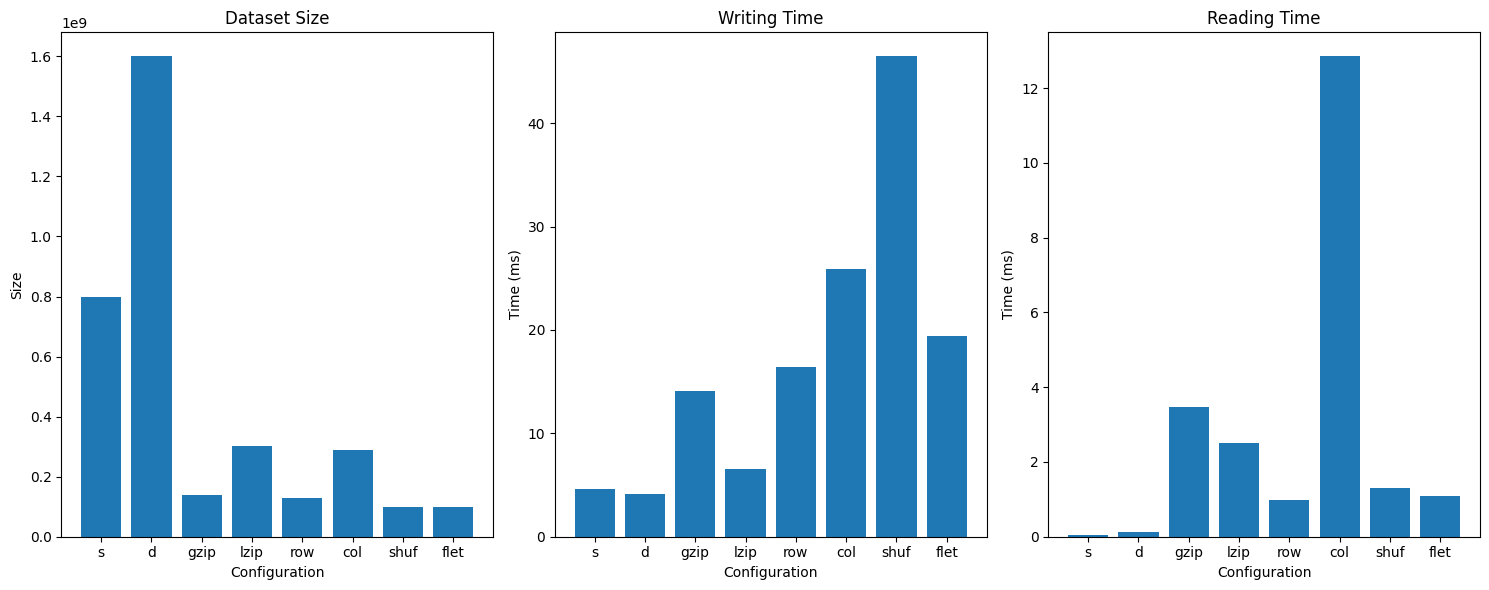

In [47]:
size_data = df[df['metric'] == 'size']
wtime_data = df[df['metric'] == 'wtime']
rtime_data = df[df['metric'] == 'rtime']

# Crear gráficos de barras
plt.figure(figsize=(15, 6))

# Gráfico de tamaño
plt.subplot(1, 3, 1)
plt.bar(size_data['name'], size_data['value'])
plt.title('Dataset Size')
plt.xlabel('Configuration')
plt.ylabel('Size')

# Gráfico de tiempo de escritura
plt.subplot(1, 3, 2)
plt.bar(wtime_data['name'], wtime_data['value'])
plt.title('Writing Time')
plt.xlabel('Configuration')
plt.ylabel('Time (ms)')

# Gráfico de tiempo de lectura
plt.subplot(1, 3, 3)
plt.bar(rtime_data['name'], rtime_data['value'])
plt.title('Reading Time')
plt.xlabel('Configuration')
plt.ylabel('Time (ms)')

plt.tight_layout()
plt.show()


In [48]:
h5file.close()

1. **Explain the differences in file sizes between the datasets with chunks and without chunks.**

    Los datasets con chunks presentan mayores tiempo de escritura y lectura pero ocupan menos espacio.

2. **Explain the differences in writing time depending on the configuration of the dataset.**

    s (sin chunks): Menor tiempo de escritura.
    gzip, lzip (con chunks y compresión): Mayores tiempos de escritura. La compresión implica una carga adicional en la CPU durante la escritura.
    row, col (chunks pequeños): Mayor tiempo de escritura en comparación con s, ya que hay más operaciones de escritura debido a los chunks más pequeños

3. **Do you appreciate any difference in reading times for the given pattern? Which is the cause of these differences?**

    Sí, hay diferencias en los tiempos de lectura para el patrón dado [::20,:].mean(axis=1). Los tiempos de lectura más altos pueden estar asociados con conjuntos de datos que tienen configuraciones que requieren más operaciones durante la lectura, como la descompresión (gzip, lzip) o la aplicación de shuffle (shuf).

4. **In your opinion, do you think that compression justifies more CPU time in exchange of less file size?**

    Sí, la compresión puede justificar más tiempo de CPU si la prioridad es reducir el tamaño del archivo en disco. La compresión puede ser beneficiosa en situaciones donde el espacio de almacenamiento es crítico, y la penalización en términos de tiempo de CPU es aceptable. Sin embargo, la elección entre compresión y tiempo de CPU dependerá de las restricciones y objetivos específicos del sistema o la aplicación.


# netCDF 

netCDF (Network Common Data Form) is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. It is also a community standard for sharing scientific data.

Since version 4 netCDF files are HDF5 files under the hood. We can apply all of our knowledge to netCDF datasets (chunking, compression).

In order to get familiar with netCDF, we will work with datasets from [CMIP](https://en.wikipedia.org/wiki/Coupled_Model_Intercomparison_Project) from the [ACCESS-ESM1-5 model](https://research.csiro.au/access/about/esm1-5/). The GCM is described in the [paper](https://doi.org/10.1071/ES19035). netCDF files can be located in [ESGF](https://esgf-node.llnl.gov/search/cmip6?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas).

You may find the netCDF files in Moodle too (`tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc`).

In [3]:
import h5py
import numpy as np
import netCDF4
import xarray
import matplotlib.pyplot as plt

Plot temperatures for `ssp245` and `ssp585` using netCDF4 and matplotlib.

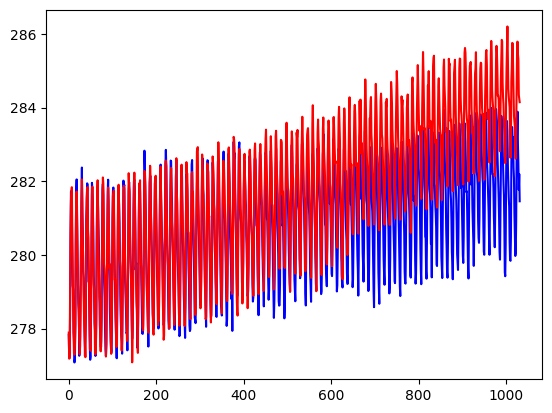

In [4]:
ds1 = netCDF4.Dataset("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
ds2 = netCDF4.Dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")

fig, ax = plt.subplots()
x = np.arange(0,ds1["time"].shape[0])
ax.plot(
    x,
    ds1["tas"][:].mean(axis=(1,2)),
    c="blue")
ax.plot(
    x,
    ds2["tas"][:].mean(axis=(1,2)),
    c="red")

ds1.close()
ds2.close()

Same plot using xarray and averaging by year (note how xarray fills the plot using metadata from the file).

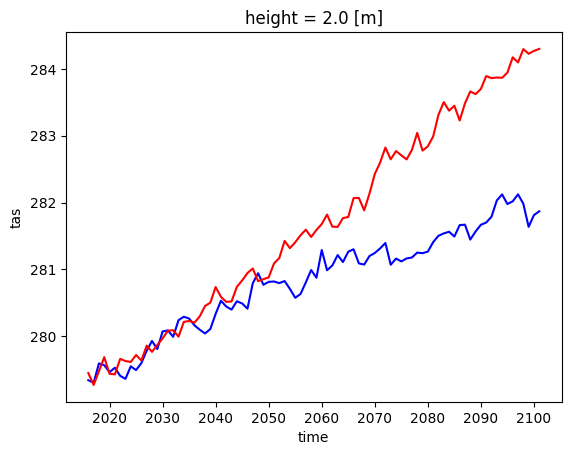

In [5]:
ds1 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
ds2 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
    
fig, ax = plt.subplots()
ds1["tas"].mean(["lat", "lon"]).resample({"time": "1Y"}).mean().plot(ax=ax,c="b")
ds2["tas"].mean(["lat", "lon"]).resample({"time": "1Y"}).mean().plot(ax=ax,c="r")

ds1.close()
ds2.close()

Since version 4 netCDF files are HDF5 files under the hood. We can apply all of our knowledge to netCDF datasets (chunking, compression).

In [44]:
# !h5dump -d tas -A tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc

El comando h5dump -d tas -A tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc se utiliza para inspeccionar el contenido del conjunto de datos netCDF en formato HDF5 con la herramienta h5dump, incluyendo sus atributos.

- d tas: Indica que se desea mostrar información sobre el conjunto de datos denominado "tas" (temperatura superficial del aire).

- A: Muestra atributos asociados al conjunto de datos.

Abrimos el archivo netCDF con HDF5:

In [7]:
f = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
list(f) # nombres de los conjuntos de datos y grupos contenidos en el archivo netCDF

['bnds',
 'height',
 'lat',
 'lat_bnds',
 'lon',
 'lon_bnds',
 'tas',
 'time',
 'time_bnds']

In [8]:
dict(f.attrs) # Convierte los atributos del objeto f (el archivo HDF5/netCDF) en un diccionario de Python

{'_nc3_strict': 1,
 'Conventions': b'CF-1.7 CMIP-6.2',
 'activity_id': b'ScenarioMIP',
 'branch_method': b'standard',
 'branch_time_in_child': array([60265.]),
 'branch_time_in_parent': array([60265.]),
 'creation_date': b'2019-11-15T02:53:44Z',
 'data_specs_version': b'01.00.30',
 'experiment': b'update of RCP4.5 based on SSP2',
 'experiment_id': b'ssp245',
 'external_variables': b'areacella',
 'forcing_index': array([1], dtype=int32),
 'frequency': b'mon',
 'further_info_url': b'https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.ssp245.none.r1i1p1f1',
 'grid': b'native atmosphere N96 grid (145x192 latxlon)',
 'grid_label': b'gn',
 'history': b'2019-11-15T02:53:44Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.',
 'initialization_index': array([1], dtype=int32),
 'institution': b'Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia',
 'institution_id': b'CSIRO',
 'mip_era': b'CMIP6',
 'nominal_resol

In [9]:
dict(f["time"].attrs) # Convierte los atributos del objeto "time" dentro del archivo HDF5/netCDF en un diccionario de Python

{'CLASS': b'DIMENSION_SCALE',
 'NAME': b'time',
 '_Netcdf4Dimid': 0,
 'bounds': b'time_bnds',
 'units': b'days since 1850-01-01',
 'calendar': b'proleptic_gregorian',
 'axis': b'T',
 'long_name': b'time',
 'standard_name': b'time',
 'REFERENCE_LIST': array([(<HDF5 object reference>, 0), (<HDF5 object reference>, 0)],
       dtype={'names': ['dataset', 'dimension'], 'formats': ['O', '<i4'], 'offsets': [0, 8], 'itemsize': 16})}

In [10]:
print(f["tas"].shape)
print(f["tas"].dtype)
print(dict(f["tas"].attrs))

(1032, 145, 192)
float32
{'standard_name': b'air_temperature', 'long_name': b'Near-Surface Air Temperature', 'comment': b'near-surface (usually, 2 meter) air temperature', 'units': b'K', 'cell_methods': b'area: time: mean', 'cell_measures': b'area: areacella', 'history': b"2019-11-15T02:53:41Z altered by CMOR: Treated scalar dimension: 'height'. 2019-11-15T02:53:41Z altered by CMOR: replaced missing value flag (-1.07374e+09) with standard missing value (1e+20).", 'coordinates': b'height', 'missing_value': array([1.e+20], dtype=float32), '_FillValue': array([1.e+20], dtype=float32), 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object)], dtype=object)}


In [11]:
dict(f["bnds"].attrs)

{'CLASS': b'DIMENSION_SCALE',
 'NAME': b'This is a netCDF dimension but not a netCDF variable.         2',
 '_Netcdf4Dimid': 3,
 'REFERENCE_LIST': array([(<HDF5 object reference>, 1), (<HDF5 object reference>, 1),
        (<HDF5 object reference>, 1)],
       dtype={'names': ['dataset', 'dimension'], 'formats': ['O', '<i4'], 'offsets': [0, 8], 'itemsize': 16})}

In [12]:
dict(f["height"].attrs)

{'units': b'm',
 'axis': b'Z',
 'positive': b'up',
 'long_name': b'height',
 'standard_name': b'height'}

In [36]:
f = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
variable_name = {}
for i in list(f):
    # print(f"Dimension de {i}:{f[i].shape}")
    shape = f[i].shape
    if isinstance(shape, tuple) and shape:
        variable_name[i] = shape[0]
    else:
        variable_name[i] = None
        
print(variable_name)

{'bnds': 2, 'height': None, 'lat': 145, 'lat_bnds': 145, 'lon': 192, 'lon_bnds': 192, 'tas': 1032, 'time': 1032, 'time_bnds': 1032}


In [37]:
f.close()

Using the [netCDF4](https://unidata.github.io/netcdf4-python) API, try to reproduce the contents of the `tas_Amon_GFDL-CM4_ssp585_r1i1p1f1_gr1_201501-210012.nc` file.

Tips:

- Create dimensions - Use [Dataset.createDimension](https://unidata.github.io/netcdf4-python/#Dataset.createDimension).
- Create variables - Use [Dataset.createVariable](https://unidata.github.io/netcdf4-python/#Dataset.createVariable).
- Create attributes - Use [Variable.setncattr](https://unidata.github.io/netcdf4-python/#Variable.setncattr).
- At each step, execute `h5dump` on the file to see how it changes.

Primero vamos a extraer todo la información que necesitaremos de cara a la construcción test.nc

In [1]:
import netCDF4

# Ruta al archivo original
file_path = "tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc"

# Abrir el archivo original
with netCDF4.Dataset(file_path, "r") as original_ds:
    # Mostrar información sobre dimensiones
    print("Dimensiones:")
    for dimname, dim in original_ds.dimensions.items():
        print(f"{dimname}: {len(dim)}")

    # Mostrar información sobre variables
    print("\nVariables:")
    for varname, var in original_ds.variables.items():
        print(f"{varname}: {var.shape}, {var.dtype}")

        # Mostrar atributos de la variable
        for attrname, attrvalue in var.__dict__.items():
            print(f"  {attrname}: {attrvalue}")

    # Mostrar atributos globales
    print("\nAtributos globales:")
    for attrname, attrvalue in original_ds.__dict__.items():
        print(f"{attrname}: {attrvalue}")

Dimensiones:
time: 1032
lat: 145
lon: 192
bnds: 2

Variables:
time: (1032,), float64
  bounds: time_bnds
  units: days since 1850-01-01
  calendar: proleptic_gregorian
  axis: T
  long_name: time
  standard_name: time
time_bnds: (1032, 2), float64
lat: (145,), float64
  bounds: lat_bnds
  units: degrees_north
  axis: Y
  long_name: Latitude
  standard_name: latitude
lat_bnds: (145, 2), float64
lon: (192,), float64
  bounds: lon_bnds
  units: degrees_east
  axis: X
  long_name: Longitude
  standard_name: longitude
lon_bnds: (192, 2), float64
height: (), float64
  units: m
  axis: Z
  positive: up
  long_name: height
  standard_name: height
tas: (1032, 145, 192), float32
  standard_name: air_temperature
  long_name: Near-Surface Air Temperature
  comment: near-surface (usually, 2 meter) air temperature
  units: K
  cell_methods: area: time: mean
  cell_measures: area: areacella
  history: 2019-11-15T02:53:41Z altered by CMOR: Treated scalar dimension: 'height'. 2019-11-15T02:53:41Z alter

* netCDF defines the sizes of all variables in terms of dimensions, so before any variables can be created the dimensions they use must be created first.
* There are two types of attributes in a netCDF file, global and variable. Global attributes provide information about a group, or the entire dataset, as a whole. Variable attributes provide information about one of the variables in a group. Global attributes are set by assigning values to Dataset or Group instance variables. Variable attributes are set by assigning values to Variable instances variables. Attributes can be strings, numbers or sequences.

**Solución del ejercicio:**

In [3]:
import h5py
# if you want, take data from the source file using h5py instead of "manually" looking at it
f = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")

# byteorder_to_endian( hdf5_dataset.dtype.byteorder )
def byteorder_to_endian(x):
    endianness = "native"
    
    if x == "<":
        endianness = "little"
    elif x == ">":
        endianness = "big"
        
    return endianness

with netCDF4.Dataset("test.nc", "w") as ds:
    
    # Creacción de las dimensiones de las variables
    bnds = ds.createDimension("bnds", size= f["bnds"].size)
    height = ds.createDimension("height", size= None)
    lat = ds.createDimension("lat", size= f["lat"].size)
    lon = ds.createDimension("lon", size= f["lon"].size)
    tas = ds.createDimension("tas", size= f["tas"].size)
    time = ds.createDimension("time", size= f["time"].size)

!h5dump -A test.nc

HDF5 "test.nc" {
GROUP "/" {
   ATTRIBUTE "_NCProperties" {
      DATATYPE  H5T_STRING {
         STRSIZE 46;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "version=2,netcdf=4.9.3-development,hdf5=1.12.2"
      }
   }
   DATASET "bnds" {
      DATATYPE  H5T_IEEE_F32BE
      DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
      ATTRIBUTE "CLASS" {
         DATATYPE  H5T_STRING {
            STRSIZE 16;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "DIMENSION_SCALE"
         }
      }
      ATTRIBUTE "NAME" {
         DATATYPE  H5T_STRING {
            STRSIZE 64;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "This is a netCDF dimension but not a netCDF variable.    

In [93]:
with netCDF4.Dataset("test.nc", "a") as ds:
    
    # Creacción de las variables:
    
    # Una dimensión
    bnds = ds.createVariable("bnds","f4",("bnds",))
    height = ds.createVariable("height", "f8", ("height",))
    lat = ds.createVariable("lat", "f8", ("lat",))
    lon = ds.createVariable("lon", "f8", ("lon",))
    time = ds.createVariable("time", "f8", ("time",))
    
    # Dos dimensiones o más
    lat_bnds = ds.createVariable("lat_bnds", "f8", ("lat", "bnds"))
    lon_bnds = ds.createVariable("lon_bnds", "f8", ("lon", "bnds"))
    time_bnds = ds.createVariable("time_bnds", "f8", ("time", "bnds"))
    tas = ds.createVariable("tas", "f4", ("time", "lat", "lon"), fill_value=1.0000000200408773e+20)

!h5dump -A test.nc

HDF5 "test.nc" {
GROUP "/" {
   ATTRIBUTE "_NCProperties" {
      DATATYPE  H5T_STRING {
         STRSIZE 46;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "version=2,netcdf=4.9.3-development,hdf5=1.12.2"
      }
   }
   DATASET "_nc4_non_coord_tas" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 1032, 145, 192 ) / ( 1032, 145, 192 ) }
      ATTRIBUTE "DIMENSION_LIST" {
         DATATYPE  H5T_VLEN { H5T_REFERENCE { H5T_STD_REF_OBJECT }}
         DATASPACE  SIMPLE { ( 3 ) / ( 3 ) }
         DATA {
         (0): (DATASET 1200 "/time"), (DATASET 562 "/lat"),
         (2): (DATASET 881 "/lon")
         }
      }
      ATTRIBUTE "_FillValue" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 1 ) / ( 1 ) }
         DATA {
         (0): 1e+20
         }
      }
      ATTRIBUTE "_Netcdf4Coordinates" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 3 )

In [95]:
with netCDF4.Dataset("test.nc", "a") as ds:
    
    # Creacción de atributos:
    
    # Atributos globales
    ds.Conventions = "CF-1.7 CMIP-6.2"
    ds.activity_id = "ScenarioMIP"
    ds.branch_method = "standard"
    ds.branch_time_in_child = 60265.0
    ds.branch_time_in_parent = 60265.0
    ds.creation_date = "2019-11-15T02:53:44Z"
    ds.data_specs_version = "01.00.30"
    ds.experiment = "update of RCP4.5 based on SSP2"
    ds.experiment_id = "ssp245"
    ds.external_variables = "areacella"
    ds.forcing_index = 1
    ds.frequency = "mon"
    ds.further_info_url = "https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.ssp245.none.r1i1p1f1"
    ds.grid = "native atmosphere N96 grid (145x192 latxlon)"
    ds.grid_label = "gn"
    ds.history = "2019-11-15T02:53:44Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards."
    ds.initialization_index = 1
    ds.institution = "Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia"
    ds.institution_id = "CSIRO"
    ds.mip_era = "CMIP6"
    ds.nominal_resolution = "250 km"
    ds.notes = "Exp: ESM-ssp245; Local ID: SSP-245-05; Variable: tas (['fld_s03i236'])"
    ds.parent_activity_id = "CMIP"
    ds.parent_experiment_id = "historical"
    ds.parent_mip_era = "CMIP6"
    ds.parent_source_id = "ACCESS-ESM1-5"
    ds.parent_time_units = "days since 1850-1-1"
    ds.parent_variant_label = "r1i1p1f1"
    ds.physics_index = 1
    ds.product = "model-output"
    ds.realization_index = 1
    ds.realm = "atmos"
    ds.run_variant = "forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113, HCFC22, HFC125, HFC134a)"
    ds.source = "ACCESS-ESM1.5 (2019): aerosol: CLASSIC (v1.0) atmos: HadGAM2 (r1.1, N96; 192 x 145 longitude/latitude; 38 levels; top level 39255 m) atmosChem: none land: CABLE2.4 landIce: none ocean: ACCESS-OM2 (MOM5, tripolar primarily 1deg; 360 x 300 longitude/latitude; 50 levels; top grid cell 0-10 m) ocnBgchem: WOMBAT (same grid as ocean) seaIce: CICE4.1 (same grid as ocean)"
    ds.source_id = "ACCESS-ESM1-5"
    ds.source_type = "AOGCM"
    ds.sub_experiment = "none"
    ds.sub_experiment_id = "none"
    ds.table_id = "Amon"
    ds.table_info = "Creation Date:(30 April 2019) MD5:e14f55f257cceafb2523e41244962371"
    ds.title = "ACCESS-ESM1-5 output prepared for CMIP6"
    ds.variable_id = "tas"
    ds.variant_label = "r1i1p1f1"
    ds.version = "v20191115"
    ds.cmor_version = "3.4.0"
    ds.tracking_id = "hdl:21.14100/d0f52779-2409-41a0-9935-df92aa9412e3"
    ds.license = "CMIP6 model data produced by CSIRO is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (https://creativecommons.org/licenses/).  Consult https://pcmdi.llnl.gov/CMIP6/TermsOfUse for terms of use governing CMIP6 output, including citation requirements and proper acknowledgment.  Further information about this data, including some limitations, can be found via the further_info_url (recorded as a global attribute in this file).  The data producers and data providers make no warranty, either express or implied, including, but not limited to, warranties of merchantability and fitness for a particular purpose. All liabilities arising from the supply of the information (including any liability arising in negligence)"

    
    # Atributos para 'time'
    time.bounds = "time_bnds"
    time.units = "days since 1850-01-01"
    time.calendar = "proleptic_gregorian"
    time.axis = "T"
    time.long_name = "time"
    time.standard_name = "time"

    # Atributos para 'lat'
    lat.bounds = "lat_bnds"
    lat.units = "degrees_north"
    lat.axis = "Y"
    lat.long_name = "Latitude"
    lat.standard_name = "latitude"
    
    # Atributos para 'lon'
    lon.bounds = "lon_bnds"
    lon.units = "degrees_east"
    lon.axis = "X"
    lon.long_name = "Longitude"
    lon.standard_name = "longitude"
    
    # Atributos para 'height'
    height.units = "m"
    height.axis = "Z"
    height.positive = "up"
    height.long_name = "height"
    height.standard_name = "height"
    
    # Atributos para 'tas'
    tas.standard_name = "air_temperature"
    tas.long_name = "Near-Surface Air Temperature"
    tas.comment = "near-surface (usually, 2 meter) air temperature"
    tas.units = "K"
    tas.cell_methods = "area: time: mean"
    tas.cell_measures = "area: areacella"
    tas.history = "2019-11-15T02:53:41Z altered by CMOR: Treated scalar dimension: 'height'. 2019-11-15T02:53:41Z altered by CMOR: replaced missing value flag (-1.07374e+09) with standard missing value (1e+20)."
    tas.coordinates = "height"
    tas.missing_value = 1.0000000200408773e+20
    tas._fillValue = 1.0000000200408773e+20
    
!h5dump -A test.nc
  
f.close()

HDF5 "test.nc" {
GROUP "/" {
   ATTRIBUTE "Conventions" {
      DATATYPE  H5T_STRING {
         STRSIZE 15;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "CF-1.7 CMIP-6.2"
      }
   }
   ATTRIBUTE "_NCProperties" {
      DATATYPE  H5T_STRING {
         STRSIZE 46;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "version=2,netcdf=4.9.3-development,hdf5=1.12.2"
      }
   }
   ATTRIBUTE "activity_id" {
      DATATYPE  H5T_STRING {
         STRSIZE 11;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "ScenarioMIP"
      }
   }
   ATTRIBUTE "branch_method" {
      DATATYPE  H5T_STRING {
         STRSIZE 8;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }


# Dimension scales 

Datasets are multidimensional arrays. HDF5 provides support for labeling the dimensions and associating one or more “dimension scales” with each dimension. A dimension scale is simply another HDF5 dataset. In principle, the length of the multidimensional array along the dimension of interest should be equal to the length of the dimension scale, but HDF5 does not enforce this property.

In [ ]:
import h5py

Using **h5py**, try to reproduce the contents of the `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` file. In order to verify that the file is correct, perform a `ncdump` on it.

Tips:

- Dimension scales - See the [docs](https://docs.h5py.org/en/stable/high/dims.html).
- Make a coordinate variable a dimension scale - `f["time"].make_scale("time")`
- Attach a dimension scale to a data variable - `f["tas"].dims[0].attach_scale(f["time"])`
- At each step, execute `h5dump` on the file to see the changes.

In [14]:
# for variable data, read it from the source file
src = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")

with h5py.File("test.nc", "w") as f:
    
    f.create_dataset(
        "time",
        src["time"].shape,
        dtype=src["time"].dtype,
        chunks=src["time"].chunks,
        compression=src["time"].compression)
    
    f.create_dataset(
        "height",
        src["height"].shape, #()
        dtype=src["height"].dtype,
        chunks=src["height"].chunks,
        compression=src["height"].compression,
        data=src["height"][()]) #Accede al valor escalar
    
    f.create_dataset(
        "lat",
        src["lat"].shape,
        dtype=src["lat"].dtype,
        chunks=src["lat"].chunks,
        compression=src["lat"].compression)
    
    f.create_dataset(
        "lon",
        src["lon"].shape,
        dtype=src["lon"].dtype,
        chunks=src["lon"].chunks,
        compression=src["lon"].compression)
    
    f.create_dataset(
        "bnds",
        src["bnds"].shape,
        dtype=src["bnds"].dtype,
        chunks=src["bnds"].chunks,
        compression=src["bnds"].compression)
    
    f.create_dataset(
        "tas",
        src["tas"].shape,
        dtype=src["tas"].dtype,
        chunks=src["tas"].chunks,
        compression=src["tas"].compression)
    
    f.create_dataset(
        "time_bnds",
        src["time_bnds"].shape,
        dtype=src["time_bnds"].dtype,
        chunks=src["time_bnds"].chunks,
        compression=src["time_bnds"].compression)
    
    f.create_dataset(
        "lat_bnds",
        src["lat_bnds"].shape,
        dtype=src["lat_bnds"].dtype,
        chunks=src["lat_bnds"].chunks,
        compression=src["lat_bnds"].compression)
    
    f.create_dataset(
        "lon_bnds",
        src["lon_bnds"].shape,
        dtype=src["lon_bnds"].dtype,
        chunks=src["lon_bnds"].chunks,
        compression=src["lon_bnds"].compression)
    
f.close()
!h5dump -A test.nc

HDF5 "test.nc" {
GROUP "/" {
   DATASET "bnds" {
      DATATYPE  H5T_IEEE_F32BE
      DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
   }
   DATASET "height" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SCALAR
   }
   DATASET "lat" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 145 ) / ( 145 ) }
   }
   DATASET "lat_bnds" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 145, 2 ) / ( 145, 2 ) }
   }
   DATASET "lon" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 192 ) / ( 192 ) }
   }
   DATASET "lon_bnds" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 192, 2 ) / ( 192, 2 ) }
   }
   DATASET "tas" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 1032, 145, 192 ) / ( 1032, 145, 192 ) }
   }
   DATASET "time" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1032 ) / ( 1032 ) }
   }
   DATASET "time_bnds" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1032, 2 ) / ( 1032, 2 ) }
   }
}
}


In [16]:
with h5py.File("test.nc", "a") as f:
    
    # Escalado
    f["time"].make_scale("time")
    f["lat"].make_scale("lat")
    f["lon"].make_scale("lon")
    f["bnds"].make_scale("bnds")
    f["tas"].dims[0].attach_scale(f["time"])
    f["tas"].dims[1].attach_scale(f["lat"])
    f["tas"].dims[2].attach_scale(f["lon"])
    f["time_bnds"].dims[0].attach_scale(f["time"])
    f["time_bnds"].dims[1].attach_scale(f["bnds"])
    f["lat_bnds"].dims[0].attach_scale(f["lat"])
    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    f["lon_bnds"].dims[0].attach_scale(f["lon"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])
    
    # Carga de los datos
    f["time"][:] = src["time"][:]
    f["height"][()] = src["height"][()]
    f["lat"][:] = src["lat"][:]
    f["lon"][:] = src["lon"][:]
    f["bnds"][:] = src["bnds"][:]
    f["tas"][:] = src["tas"][:]
    f["lat_bnds"][:] = src["lat_bnds"][:]
    f["lon_bnds"][:] = src["lon_bnds"][:]
    f["time_bnds"][:] = src["time_bnds"][:]  

f.close()
!h5dump -A test.nc

HDF5 "test.nc" {
GROUP "/" {
   DATASET "bnds" {
      DATATYPE  H5T_IEEE_F32BE
      DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
      ATTRIBUTE "CLASS" {
         DATATYPE  H5T_STRING {
            STRSIZE 16;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "DIMENSION_SCALE"
         }
      }
      ATTRIBUTE "NAME" {
         DATATYPE  H5T_STRING {
            STRSIZE 5;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "bnds"
         }
      }
      ATTRIBUTE "REFERENCE_LIST" {
         DATATYPE  H5T_COMPOUND {
            H5T_REFERENCE { H5T_STD_REF_OBJECT } "dataset";
            H5T_STD_U32LE "dimension";
         }
         DATASPACE  SIMPLE { ( 6 ) / ( 6 ) }
         DATA {
         (0): {
               DATASET 4912 "/time_bnds",
               1
      

In [17]:
exclude_attributes = ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"]

with h5py.File("test.nc", "a") as f:
    for variable_name in ["time", "height", "bnds", "lon", "lat", "tas", "time_bnds", "lat_bnds", "lon_bnds"]:
        for attr_name, attr_value in src[variable_name].attrs.items():
            # Verificar si el atributo debe ser excluido
            if attr_name not in exclude_attributes and not attr_name.startswith("_"):
                f[variable_name].attrs[attr_name] = attr_value

f.close()
src.close()
!h5dump -A test.nc

HDF5 "test.nc" {
GROUP "/" {
   DATASET "bnds" {
      DATATYPE  H5T_IEEE_F32BE
      DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
      ATTRIBUTE "CLASS" {
         DATATYPE  H5T_STRING {
            STRSIZE 16;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "DIMENSION_SCALE"
         }
      }
      ATTRIBUTE "NAME" {
         DATATYPE  H5T_STRING {
            STRSIZE 5;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "bnds"
         }
      }
      ATTRIBUTE "REFERENCE_LIST" {
         DATATYPE  H5T_COMPOUND {
            H5T_REFERENCE { H5T_STD_REF_OBJECT } "dataset";
            H5T_STD_U32LE "dimension";
         }
         DATASPACE  SIMPLE { ( 6 ) / ( 6 ) }
         DATA {
         (0): {
               DATASET 4912 "/time_bnds",
               1
      

# Virtual dataset 

Virtual datasets allow a number of real datasets to be mapped together into a single, sliceable dataset via an interface layer. The mapping can be made ahead of time, before the parent files are written, and is transparent to the parent dataset characteristics (chunking, compression etc…). The datasets can be meshed in arbitrary combinations, and even the data type converted. Once a virtual dataset has been created, it can be read just like any other HDF5 dataset.

Using **h5py**, perform an ETL over the files `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc`. Create a Virtual Dataset (VDS) with a time dimension and coordinate that spans the full time period from 2015 to 2300.

Finally, use xarray to check that the ETL has been performed succesfully. Also, plot the spatial mean of temperature resampling by year.

Tips:

- h5py Virtual Dataset - See the [docs](https://docs.h5py.org/en/stable/vds.html).
- Create a VirtualLayout object representing the dimensions and data type of the virtual dataset.
- Create a number of VirtualSource objects, representing the datasets the array will be built from.
- Map slices from the sources into the layout.
- Convert the VirtualLayout object into a virtual dataset in an HDF5 file.

In [4]:
import h5py
import xarray

In [23]:
# Archivos de origen
src1 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
src2 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc")

# Crear un archivo para el Virtual Dataset
with h5py.File("vds.h5", "w") as f:
    ## time 
    time_layout = h5py.VirtualLayout(shape=(3432,), dtype='float64') 
    time_vs1 = h5py.VirtualSource(src1["time"]) 
    time_layout[0:1032,] = time_vs1 
    time_vs2 = h5py.VirtualSource(src2["time"]) 
    time_layout[1032:3432,] = time_vs2 

    time = f.create_virtual_dataset("time", time_layout) # Crear un conjunto de datos virtual en el archivo
    
    ## lat
    lat_layout = h5py.VirtualLayout(shape=(145,), dtype='float64') 
    lat_vs1 = h5py.VirtualSource(src1["lat"]) 
    lat_layout[:,] = lat_vs1 
    
    lat = f.create_virtual_dataset("lat", lat_layout) 
    
    ## lon
    lon_layout = h5py.VirtualLayout(shape=(192,), dtype='float64') 
    lon_vs1 = h5py.VirtualSource(src1["lon"]) 
    lon_layout[:,] = lon_vs1 

    lon = f.create_virtual_dataset("lon", lon_layout) 
    
    ## bnds
    bnds_layout = h5py.VirtualLayout(shape=(2,), dtype='float32') 
    bnds_vs1 = h5py.VirtualSource(src1["bnds"])
    bnds_layout[...] = bnds_vs1  # Cargar en todo el VirtualLayout
    
    bnds = f.create_virtual_dataset("bnds", bnds_layout)
    
    ## time_bnds
    time_bnds_layout = h5py.VirtualLayout(shape=(3432, 2), dtype='float64') 
    time_bnds_vs1 = h5py.VirtualSource(src1["time_bnds"]) 
    time_bnds_layout[:1032, :] = time_bnds_vs1 
    time_bnds_vs2 = h5py.VirtualSource(src2["time_bnds"]) 
    time_bnds_layout[1032:, :] = time_bnds_vs2 
    
    time_bnds = f.create_virtual_dataset("time_bnds", time_bnds_layout) 
    
    ## lat_bnds
    lat_bnds_layout = h5py.VirtualLayout(shape=(145, 2), dtype='float64') 
    lat_bnds_vs1 = h5py.VirtualSource(src1["lat_bnds"]) 
    lat_bnds_layout[:, :] = lat_bnds_vs1 

    
    lat_bnds = f.create_virtual_dataset("lat_bnds", lat_bnds_layout) 
    
    ## lon_bnds
    lon_bnds_layout = h5py.VirtualLayout(shape=(192, 2), dtype='float64') 
    lon_bnds_vs1 = h5py.VirtualSource(src1["lon_bnds"]) 
    lon_bnds_layout[:, :] = lon_bnds_vs1 

    
    lon_bnds = f.create_virtual_dataset("lon_bnds", lon_bnds_layout) 
    
    ## tas
    tas_layout = h5py.VirtualLayout(shape=(3432, 145, 192), dtype='float64') 
    tas_vs1 = h5py.VirtualSource(src1["tas"]) 
    tas_layout[:1032, :, :] = tas_vs1 
    tas_vs2 = h5py.VirtualSource(src2["tas"]) 
    tas_layout[1032:, :, :] = tas_vs2 
    
    tas = f.create_virtual_dataset("tas", tas_layout) 
    
    ## height
    height_layout = h5py.VirtualLayout(shape=(), dtype='float64') 
    height_vs1 = h5py.VirtualSource(src1["height"]) 
    height_vs2 = h5py.VirtualSource(src2["height"]) 
    height_layout[()] = height_vs1 # Es un escalar (2.0) nos vale cualquiera de los dos

    height = f.create_virtual_dataset("height", height_layout) 
    
    ## Escalado
    
    f["time"].make_scale("time") 
    f["lat"].make_scale("lat")
    f["lon"].make_scale("lon")
    f["bnds"].make_scale("bnds") 
    f["time_bnds"].dims[0].attach_scale(f["time"])
    f["time_bnds"].dims[1].attach_scale(f["bnds"])
    f["lat_bnds"].dims[0].attach_scale(f["lat"])
    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    f["lon_bnds"].dims[0].attach_scale(f["lon"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])
    f["tas"].dims[0].attach_scale(f["time"])
    f["tas"].dims[1].attach_scale(f["lat"])
    f["tas"].dims[2].attach_scale(f["lon"])
    
    # Carga de atributos
    
    for attr_name, attr_value in src1["time"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            time.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["lat"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            lat.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["lon"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            lon.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["bnds"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            bnds.attrs[attr_name] = attr_value    
    for attr_name, attr_value in src1["time_bnds"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            time_bnds.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["lat_bnds"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            lat_bnds.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["lon_bnds"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            lon_bnds.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["tas"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            tas.attrs[attr_name] = attr_value
    for attr_name, attr_value in src1["height"].attrs.items():
        if attr_name not in ["DIMENSION_LIST", "REFERENCE_LIST", "NAME", "CLASS"] and not attr_name.startswith("_"):
            height.attrs[attr_name] = attr_value

f.close()
src1.close()
src2.close()

In [24]:
# everything ok?

src1 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", use_cftime=True)
src2 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc", use_cftime=True)
ds = xarray.open_dataset("vds.h5", use_cftime= True)

print("VDS mean: {}, source mean: {}, OK: {}".format(
    ds["tas"].sel(time=slice("2015-01-01", "2100-12-31")).mean().values,
    src1["tas"].mean().values,
    (ds["tas"].sel(time=slice("2015-01-01", "2100-12-31")).mean() == src1["tas"].mean()).values))

print("VDS mean: {}, source mean: {}, OK: {}".format(
    ds["tas"].sel(time=slice("2101-01-01", "2300-12-31")).mean().values,
    src2["tas"].mean().values,
    (ds["tas"].sel(time=slice("2101-01-01", "2300-12-31")).mean() == src2["tas"].mean()).values))

VDS mean: 281.68944996870647, source mean: 281.6891784667969, OK: False
VDS mean: 288.7419976097423, source mean: 288.7425537109375, OK: False


Si tenemos en cuenta un redondeo el ejercicio a funcionado de manera correcta.

# Discrete Sampling Geometries

Discrete sampling geometry datasets are characterized by a dimensionality that is lower than that of the space-time region that is sampled.

The [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) is an integrated database of daily climate summaries from land surface stations across the globe. GHCNd contains records from more than 100,000 stations in 180 countries and territories. NCEI provides numerous daily variables, including maximum and minimum temperature, total daily precipitation, snowfall, and snow depth. Both record length and period of record vary by station and cover intervals ranging from less than a year to more than 175 years. See [this](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt).

In this exercise we will store a small subset of GHCNd in two different formats, as a Coordinate Matrix and as a Discrete Sampling Geometry. For the Coordinate Matrix you will use [compound data types](https://docs.h5py.org/en/stable/high/dataset.html#reading-writing-data) and you will need to use [resizable datasets](https://docs.h5py.org/en/stable/high/dataset.html#resizable-datasets) for the Discrete Sampling Geometry.

In [26]:
import math, codecs
import numpy as np
import pandas as pd
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime, datetime

Load an plot stations from GHCNd in the region of Spain and Canary Islands.

In [36]:
def parse_station(line):
    station = tuple([
        line[0:11].rstrip(),
        float(line[12:20].rstrip()),
        float(line[21:30].rstrip()),
        float(line[31:37].rstrip()),
        line[38:40].rstrip(),
        line[41:71].rstrip(),
        line[72:75].rstrip(),
        line[76:79].rstrip(),
        line[80:85].rstrip('\n').rstrip(),
    ])

    return station

def parse_stations(f):
    for line in codecs.open(f, 'r', encoding='utf-8', errors='ignore'):
        station = parse_station(line)
        yield station

csvs = [
    "./stations/SP000008027.csv",
    "./stations/SP000008181.csv",
    "./stations/SPE00119711.csv",
    "./stations/SPE00119882.csv",
    "./stations/SPE00119936.csv",
    "./stations/SPE00119972.csv",
    "./stations/SPE00120278.csv",
    "./stations/SPE00120458.csv",
    "./stations/SPE00120467.csv",
]

values_dtype = np.dtype([
    ('station_id', 'S11'),
    ('date', 'S8'),
    ('var', 'S4'),
    ('value', 'f4'),
    ('mflag', 'S1'),
    ('qflag', 'S1'),
    ('sflag', 'S1'),
    ('obstime', 'S4'),
])

stations_dtype = np.dtype([
            ('station_id', 'S11'),
            ('lat', 'f8'),
            ('lon', 'f8'),
            ('elevation', 'f4'),
            ('state', 'S2'),
            ('name', h5py.string_dtype("utf-8", 30)),
            ('gsn_flag', 'S3'),
            ('hcn_crn_flag', 'S3'),
            ('wmo_id', 'S5'),
])
stations_file = "./stations/stations.txt"
stations = np.array([x for x in parse_stations(stations_file)], dtype=stations_dtype)
stations

array([(b'SP000008027', 43.3075,  -2.0392, 251., b'', b'SAN SEBASTIAN - IGUELDO', b'GSN', b'', b'08027'),
       (b'SP000008181', 41.2928,   2.0697,   4., b'', b'BARCELONA/AEROPUERTO', b'GSN', b'', b'08181'),
       (b'SPE00119711', 43.3669,  -8.4192,  58., b'', b'A CORUNA', b'', b'', b'08001'),
       (b'SPE00119882', 39.5556,   2.6264,   3., b'', b'PALMA DE MALLORCA CMT', b'', b'', b'08306'),
       (b'SPE00119936', 36.5008,  -6.2567,   1., b'', b'CADIZ', b'', b'', b'08452'),
       (b'SPE00119972', 43.4644,  -3.8189,  64., b'', b'SANTANDER CENTRO', b'', b'', b''),
       (b'SPE00120278', 40.4667,  -3.5556, 609., b'', b'MADRID/BARAJAS', b'', b'', b'08221'),
       (b'SPE00120458', 28.4631, -16.2553,  35., b'', b'STA. CRUZ DE TENERIFE', b'', b'', b'60020'),
       (b'SPE00120467', 28.4775, -16.3292, 632., b'', b'TENERIFE/LOS RODEOS', b'', b'', b'60015')],
      dtype=[('station_id', 'S11'), ('lat', '<f8'), ('lon', '<f8'), ('elevation', '<f4'), ('state', 'S2'), ('name', 'S30'), ('gsn_f

/home/carlos/projects/Clase/Modelos de datos/myvenv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


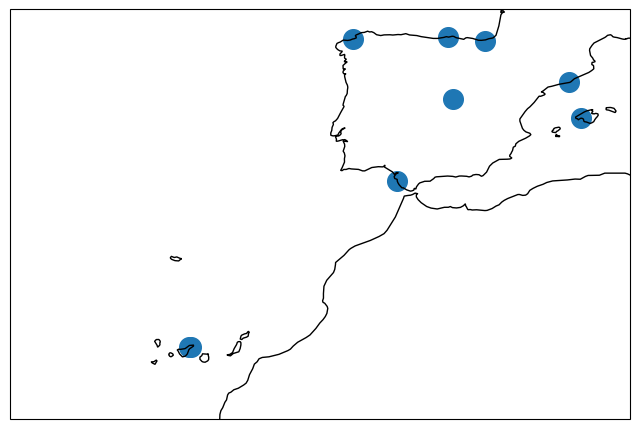

In [29]:
fig=plt.figure(figsize=(8,6))

ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-25,5,25,44])
ax.scatter(stations["lon"], stations["lat"], s=200)

Create the coordinate matrix dataset.

In [30]:
# write data in COO format
with h5py.File("coo.h5", "w") as f:
    pass
        
# load data and plot
with h5py.File("coo.h5", "r") as f:
    pass

Create the discrete sampling geometry dataset.

In [ ]:
MISSING = 999.9
VS = [
    # name -> original name
    # cfname -> name in the netCDF file
    # attrs -> variable attributes
    {
        "name": "PRCP",
        "cfname": "pr",
        "attrs":
            {
                "standard_name": "precipitation_flux",
                "coordinates": "time lat lon alt",
                "units": "kg m-2 s-1"
            }
    },
    {
        "name": "TMAX",
        "cfname": "tasmax",
        "attrs":
            {
                "standard_name": "air_temperature",
                "coordinates": "time lat lon alt",
                "units": "K",
            }
    },
    {
        "name": "TMIN",
        "cfname": "tasmin",
        "attrs":
            {
                "standard_name": "air_temperature",
                "coordinates": "time lat lon alt",
                "units": "K",
            }
    },
]

def create_char_attr(o,k,v):
    o.attrs.create(k,v,dtype="S"+str(len(v)))

def create_dimension(g,n,s,t):
    d = f.create_dataset(n, s, dtype=t)
    d.attrs.create(
        "NAME",
        "This is a netCDF dimension but not a netCDF variable.    " + n,
        dtype="S"+str(len("This is a netCDF dimension but not a netCDF variable.    " + n)))

    return d

with h5py.File("dsg.h5", "w") as f:
    create_char_attr(f, "featureType", "TimeSeries")
    create_char_attr(f, "cdm_data_type", "TimeSeries")
    create_char_attr(f, "Conventions", "COARDS, CF-1.6, ACDD-1.3")

    name_strlen_dset = create_dimension(f, "name_strlen", (11,), "S1")
    timeseries_dset = create_dimension(f, "timeseries", (len(stations["station_id"]),), "f4")

    lon = f.create_dataset(
        "lon",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    lon.dims[0].attach_scale(timeseries_dset)
    create_char_attr(lon, "standard_name", "longitude")
    create_char_attr(lon, "long_name", "station longitude")
    create_char_attr(lon, "units", "degrees_east")
    create_char_attr(lon, "axis", "X")
    create_char_attr(lon, "_CoordinateAxisType", "Longitude")

    lat = f.create_dataset(
        "lat",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    lat.dims[0].attach_scale(timeseries_dset)
    create_char_attr(lat, "standard_name", "latitude")
    create_char_attr(lat, "long_name", "station latitude")
    create_char_attr(lat, "units", "degrees_north")
    create_char_attr(lat, "axis", "Y")
    create_char_attr(lat, "_CoordinateAxisType", "Latitude")

    alt = f.create_dataset(
        "alt",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    alt.dims[0].attach_scale(timeseries_dset)
    create_char_attr(alt, "long_name", "vertical distance above the surface")
    create_char_attr(alt, "standard_name", "height")
    create_char_attr(alt, "units", "m")
    create_char_attr(alt, "positive", "up")
    create_char_attr(alt, "axis", "Z")
    create_char_attr(alt, "_CoordinateAxisType", "Height")

    station = f.create_dataset(
        "station",
        (len(stations["station_id"]), 11),
        dtype="S1")
    create_char_attr(station, "long_name", "station name")
    create_char_attr(station, "ioos_category", "Identifier")
    create_char_attr(station, "long_name", "Station")
    create_char_attr(station, "cf_role", "timeseries_id")
    station.dims[0].attach_scale(timeseries_dset)
    station.dims[1].attach_scale(name_strlen_dset)

    obs_dset = f.create_dataset(
        "obs",
        (0,),
        "i4",
        maxshape=(None,))
    obs_dset.make_scale("obs")
    obs_dset.attrs.create(
        "NAME",
        "This is a netCDF dimension but not a netCDF variable.    " + "obs",
        dtype="S"+str(len("This is a netCDF dimension but not a netCDF variable.    " + "obs")))
    time = f.create_dataset(
        "time",
        (obs_dset.shape[0],),
        maxshape=(None,),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True)
    create_char_attr(time, "standard_name", "time")
    create_char_attr(time, "long_name", "time of measurement")
    create_char_attr(time, "units", "days since 1900-01-01 00:00:00")
    create_char_attr(time, "calendar", "gregorian")
    create_char_attr(time, "axis", "T")
    create_char_attr(time, "_CoordinateAxisType", "Time")
    time.dims[0].attach_scale(obs_dset)

    for v in VS:
        f.create_dataset(
            v["cfname"],
            (obs_dset.shape[0],),
            fillvalue=MISSING,
            maxshape=(None,),
            dtype="f4",
            compression="gzip",
            shuffle=True,
            fletcher32=True)
        f[v["cfname"]].dims[0].attach_scale(obs_dset)
        f[v["cfname"]].attrs.create("missing_value", MISSING)
        for attr in v["attrs"]:
            create_char_attr(f[v["cfname"]], attr, v["attrs"][attr])

    rowSize = f.create_dataset(
        "rowSize",
        (timeseries_dset.shape[0],),
        dtype="i4")
    rowSize.dims[0].attach_scale(timeseries_dset)
    create_char_attr(rowSize, "long_name", "Number of Observations for this TimeSeries")
    create_char_attr(rowSize, "sample_dimension", "obs")

    # values
    lat[:] = stations["lat"]
    lon[:] = stations["lon"]
    alt[:] = stations["elevation"]
    station[:] = stations["station_id"].astype("S11").view("S1").reshape(len(stations),-1)
    f["rowSize"][:] = 0

    # fill the values from CSVs
    for st in stations["station_id"].view("S11").ravel():
        pass

In [ ]:
!ncdump -hs dsg.h5

# Zarr 

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. Zarr features are:

- Create N-dimensional arrays with any NumPy dtype.
- Chunk arrays along any dimension.
- Compress and/or filter chunks using any NumCodecs codec.
- Store arrays in memory, on disk, inside a Zip file, **on S3**, **GCS**, …
- Read an array concurrently from multiple threads or processes.
- Write to an array concurrently from multiple threads or processes.
- Organize arrays into hierarchies via groups.


In [19]:
import h5py
import zarr
import numpy as np
import xarray
from numcodecs import Blosc, GZip
import gcsfs

Reproduce the random walker example using both h5py and zarr with the following parameters:

- Number of samples (n): 100\_000
- Length of each sample (l): 200

Using h5py:

In [41]:
n = 100_000
l = 200
cs = 1000
chunks = (cs, l)

with h5py.File('walks.h5', 'w') as f:
    d = f.create_dataset('walks', shape=(n, l), dtype='i8')
    for i in range(n // cs):
        walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
        d[i*cs:(i+1)*cs] = walks[:]
        
with h5py.File('walks-compressed.h5', 'w') as f:
    d = f.create_dataset('walks',
                         shape=(n, l),
                         dtype='i8',
                         chunks=chunks,
                         compression="gzip",
                         compression_opts=5)
    for i in range(n // cs):
        walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
        d[i*cs:(i+1)*cs] = walks[:]

Using zarr:

In [42]:
z = zarr.open(
    'walks.zarr',
    mode='w')

z.create_dataset(
    'walks',
    shape=(n, l),
    chunks=chunks,
    dtype='i8',
    compressor=None)

for i in range(n // cs):
    walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
    z["walks"][i*cs:(i+1)*cs] = walks[:]
    
compressor = GZip(5)
d = z.create(
    "compressed",
    shape=(n,l),
    dtype="i8",
    chunks=chunks,
    compressor=compressor,
    overwrite=True)

for i in range(n // cs):
    walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
    d[i*cs:(i+1)*cs] = walks[:]

Accesing cloud climate data using zarr.

In [20]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token="anon")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = "gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r2i1p1f1/Amon/tas/gn/v20200226"

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xarray.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 96, nbnd: 2, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, nbnd) float64 ...
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, nbnd) float64 ...
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           10950.0
    ...                              ...
    tracking_id:                     hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    variable_id:                     tas
    variant_info:                    CMIP6 CESM2-FV2 historical experiment (1...
    variant_label:                   r2i1p1f1
    netcdf_tracking_ids:             hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    version_id:                      v20200226

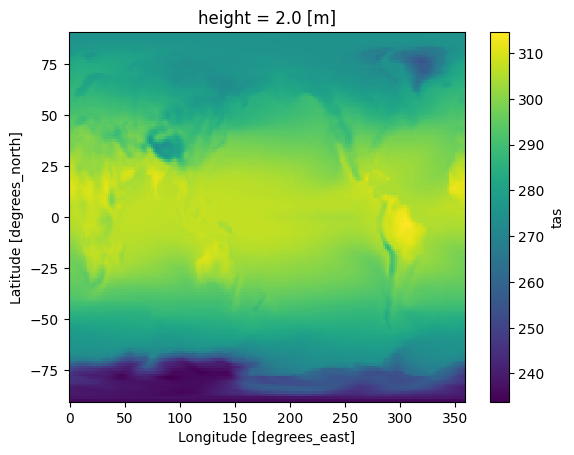

In [44]:
ds["tas"].mean("time").plot()

# Exercise

Using Google Cloud Storage, locate the dataset that contains the time series for the files `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc` (note that the cloud dataset contains concatenated time series rather than individual files like the ones found in [ESGF](https://esgf-node.llnl.gov/search/cmip6?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas)). Plot the spatial mean of the temperature averaged by year.

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


mip_era
CMIP6:
<mip_era>/
      <activity_id>/
          <institution_id>/
              <source_id>/
                  <experiment_id>/
                      <member_id>/
                          <table_id>/
                              <variable_id>/
                                  <grid_label>/
                                      <version>/
                                        <CMOR filename>.nc


Extraemos de los archivos la información de los artibutos globales para realizar la busqueda en Google Cloud

In [22]:
src1 = 'tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc'
src2 = 'tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc'

# Función para imprimir atributos globales específicos

def print_global_attributes(ds, attributes_to_find):
    print("\nAtributos globales:")
    for attrname, attrvalue in ds.__dict__.items():
        if attrname in attributes_to_find:
            print(f"{attrname}: {attrvalue}")

# Atributos que se están buscando

attributes_to_find = ['activity_id', 'institution_id', 'source_id', 'experiment_id',
                      'member_id', 'table_id', 'variable_id', 'grid_label',
                      'zstore', 'dcpp_init_year', 'version', 'variant_label']

In [23]:
# Abrir cada archivo y mostrar atributos globales específicos

ds1 = netCDF4.Dataset(src1, "r")
print(f"Información para el archivo: {src1}")
print(print_global_attributes(ds1, attributes_to_find))
ds1.close()  

ds2 = netCDF4.Dataset(src2, "r")
print(f"Información para el archivo: {src1}")
print(print_global_attributes(ds2, attributes_to_find))
ds2.close()   

Información para el archivo: tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

Atributos globales:
activity_id: ScenarioMIP
experiment_id: ssp585
grid_label: gn
institution_id: CSIRO
source_id: ACCESS-ESM1-5
table_id: Amon
variable_id: tas
variant_label: r1i1p1f1
version: v20191115
None
Información para el archivo: tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

Atributos globales:
activity_id: ScenarioMIP
experiment_id: ssp585
grid_label: gn
institution_id: CSIRO
source_id: ACCESS-ESM1-5
table_id: Amon
variable_id: tas
variant_label: r1i1p1f1
version: v20210318
None


Realizamos la busqueda de los parametros

In [28]:
df_tas = df.query("activity_id == 'ScenarioMIP'")
df_tas = df_tas.query("institution_id == 'CSIRO'")
df_tas = df_tas.query("source_id == 'ACCESS-ESM1-5'")
df_tas = df_tas.query("experiment_id == 'ssp585'")
df_tas = df_tas.query("member_id == 'r1i1p1f1'")
df_tas = df_tas.query("table_id == 'Amon'")
df_tas = df_tas.query("variable_id == 'tas'")
df_tas

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
517658,ScenarioMIP,CSIRO,ACCESS-ESM1-5,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1...,NaN,20210318


/home/carlos/projects/Clase/Modelos de datos/myvenv/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/carlos/projects/Clase/Modelos de datos/myvenv/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/carlos/projects/Clase/Modelos de datos/myvenv/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


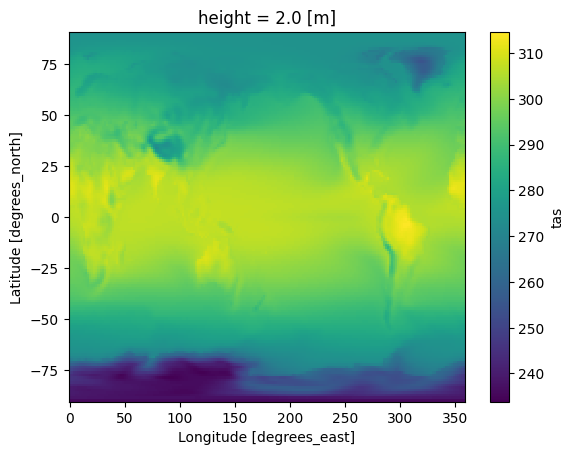

In [29]:
gcs = gcsfs.GCSFileSystem(token = 'anon')
zstore = df_tas.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds = xarray.open_zarr(mapper, consolidated = True)
ds["tas"].mean("time").plot()